In [1]:
import pandas as pd
import numpy as np
import cv2

import os

from matplotlib import pyplot as plt

from tqdm.auto import tqdm


In [2]:
root_dir = '/data/siim-covid19-detection/'
image_size = 640
save_dir = f'{root_dir}{image_size}/train_mask'
os.makedirs(save_dir, exist_ok=True)

In [3]:
train = pd.read_csv(f'{root_dir}train_image_level.csv')
train

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [4]:
meta = pd.read_csv(f'{root_dir}/meta.csv')
meta = meta[meta.split=='train'].reset_index(drop=True)

train['id'] = train.apply(lambda row: row.id.split('_')[0], axis=1)
train = train.rename(columns={'id': 'image_id'})
train_meta = pd.merge(train, meta, how='inner', on='image_id')
train_meta = train_meta.drop(['boxes', 'split', 'StudyInstanceUID'], axis=1)
train_meta

,image_id,label,dim0,dim1
0,000a312787f2,opacity 1 789.28836 582.43035 1815.94498 2499....,3488,4256
1,000c3a3f293f,none 1 0 0 1 1,2320,2832
2,0012ff7358bc,opacity 1 677.42216 197.97662 1545.21983 1197....,2544,3056
3,001398f4ff4f,opacity 1 2729 2181.33331 3677.00012 2785.33331,3520,4280
4,001bd15d1891,opacity 1 623.23328 1050 1337.23328 2156 opaci...,2800,3408
...,...,...,...,...
6329,ffcc6edd9445,none 1 0 0 1 1,4240,3480
6330,ffd91a2c4ca0,none 1 0 0 1 1,2800,3408
6331,ffd9b6cf2961,opacity 1 2197.38566 841.07361 2513.80265 1292...,2388,3050
6332,ffdc682f7680,opacity 1 2729.27083 332.26044 4225.52099 2936...,3488,4256


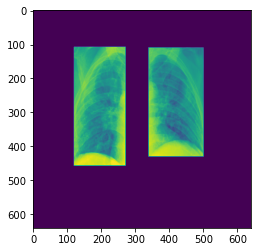

In [5]:
image_id = '000a312787f2'
i = int(train_meta[train_meta.image_id==image_id].index.values)
image_path = f'{root_dir}{image_size}/train/{image_id}.png'
image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

label = train_meta.loc[i, 'label'].split()
if label != 'none':
    label = label
    dim0 = train_meta.loc[i, 'dim0']
    dim1 = train_meta.loc[i, 'dim1']

    mask = np.zeros((image_size, image_size), dtype=np.uint8)
    for j in range(len(label) // 6):
        xmin = int(np.round(float(label[6*j+2])*image_size/dim1, 4))
        ymin = int(np.round(float(label[6*j+3])*image_size/dim0, 4))
        xmax = int(np.round(float(label[6*j+4])*image_size/dim1, 4))
        ymax = int(np.round(float(label[6*j+5])*image_size/dim0, 4))
#         mask[ymin:ymax, xmin:xmax] = image[ymin:ymax, xmin:xmax]
#         cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=(0,255,0), thickness=2)
        cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=255, thickness=-1)


    plt.imshow(mask)

In [6]:
for i in tqdm(range(len(train_meta))):
    label = train_meta.loc[i, 'label'].split()
    
#     if label[0] == 'none':
#         continue
    
    image_id = train_meta.loc[i, 'image_id']
    dim0 = train_meta.loc[i, 'dim0']
    dim1 = train_meta.loc[i, 'dim1']
    
    image_path = f'{root_dir}{image_size}/train/{image_id}.png'
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    
    mask = np.zeros((image_size, image_size), dtype=np.uint8)
    for j in range(len(label) // 6):
        xmin = int(np.round(float(label[j*6+2])*image_size/dim1, 4))
        ymin = int(np.round(float(label[j*6+3])*image_size/dim0, 4))
        xmax = int(np.round(float(label[j*6+4])*image_size/dim1, 4))
        ymax = int(np.round(float(label[j*6+5])*image_size/dim0, 4))
#         mask[ymin:ymax, xmin:xmax] = image[ymin:ymax, xmin:xmax]
        cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=255, thickness=-1)
    cv2.imwrite(f'{save_dir}/{image_id}.png', mask)